In [24]:
#Loading Libraries 

library(BiocSingular)
library(SingleCellExperiment)
library(scuttle)
library(scran)
library(scater)
library(GO.db)
library(limma)
library(org.Hs.eg.db)
#library(scDblFinder)
#library(DropletUtils)
#library(DropletTestFiles)
library(uwot)
#library(rtracklayer)
#library(PCAtools)
#library(celldex)
#library(SingleR)
#library(batchelor)
library(bluster)


In [1]:
load("data/phenotype_with_ID.RData")
load("merge2.RData")

We have now loaded pre-processed merge2 data, and the associated phenotypes. Lets create an index linking cells to  phenotype as well. 

In [11]:
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)

Great, now lets begin by doing PCA on our SCE object called merge2. First, we will take the top 30% of the genes, and then we will do PCA on that. 

In [29]:
#PCA has already been done on the top genes 
reducedDimNames(merge2)

[1] "PCA.cc"    "UMAP.cc"   "PCA.5k"    "PCA.nocc"  "UMAP.nocc" "TSNE.nocc"
[7] "TSNE.5k"   "PCA"       "TSNE"

Ok nice - next we add phenotype metadata

In [30]:
# Add phenotypes as a column in colData
colData(merge2)$Phenotype <- pheno.merge2

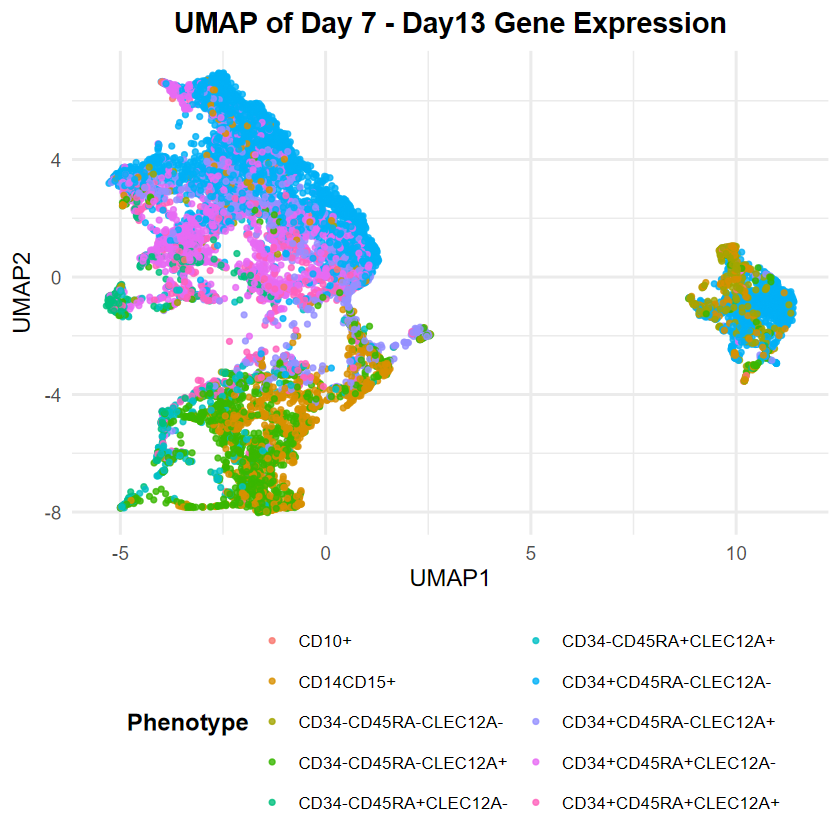

In [43]:
gg_umap <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Phenotype)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day13 Gene Expression",
    x = "UMAP1",
    y = "UMAP2",
    color = "Phenotype"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.title = element_text(face = "bold"),
    legend.box = "horizontal",
    legend.text = element_text(size = 10)  # Adjust legend text size
  ) +
  guides(color = guide_legend(nrow = 5))  # Split legend into 2 rows

print(gg_umap)


Too many groups, lets simplify 

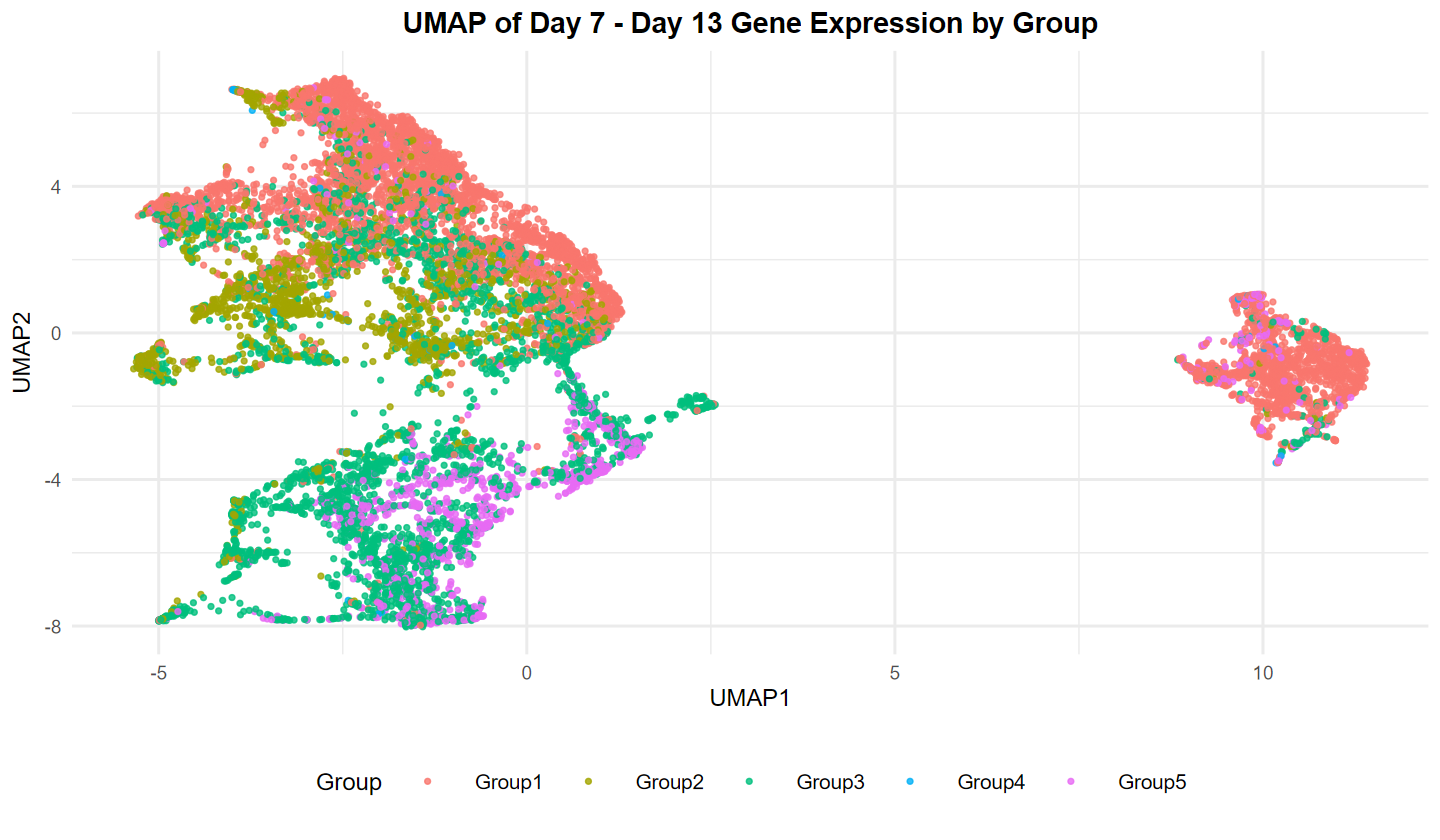

In [148]:
#Establishing Population Groups 

# Define phenotype groups
phenotype_groups <- list(
  Group1 = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-"), # Ra-C-
  Group2 = c("CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"),   #Ra+C-
  Group3 = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), #C+
  Group4 = "CD10+", #Pro -B
  Group5 = "CD14CD15+" #Pro-NM
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)]
  if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels

# Extract UMAP coordinates and group labels for plotting
umap_df <- as.data.frame(reducedDim(merge2, "UMAP"))
umap_df$Group <- colData(merge2)$Group

# Create UMAP plot
library(ggplot2)

gg_umap <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day 13 Gene Expression by Group",
    x = "UMAP1",
    y = "UMAP2",
    color = "Group"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.text = element_text(size = 12),       # Increase legend text size
    legend.key.size = unit(1.5, "cm")           # Increase legend color box size
  )

# Print the UMAP plot
print(gg_umap)

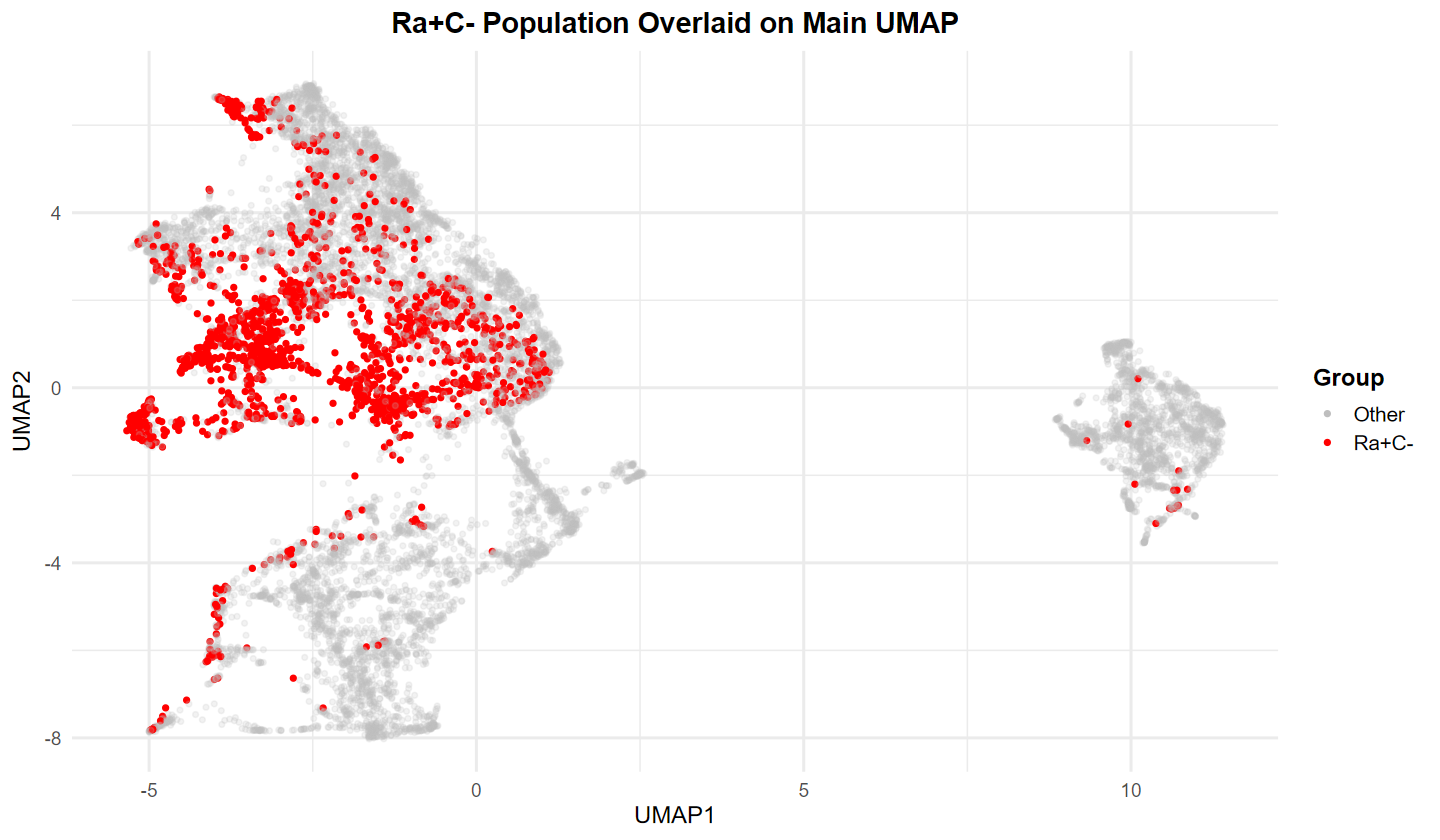

In [158]:
gg_umap <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Group2", "Ra+C-", "Other")),
             alpha = ifelse(umap_df$Group == "Group2", 1, 0.2), size = 1) +
  scale_color_manual(
    values = c("Ra+C-" = "red", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "Ra+C- Population Overlaid on Main UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )

# Print the UMAP plot
print(gg_umap)


In [51]:
rownames(assay(merge2, "logcounts"))

[1] "MIR1302-2HG"       "FAM138A"           "OR4F5"            
    [4] "AL627309.1"        "AL627309.3"        "AL627309.2"       
    [7] "AL627309.5"        "AL627309.4"        "AP006222.2"       
   [10] "AL732372.1"        "OR4F29"            "AC114498.1"       
   [13] "OR4F16"            "AL669831.2"        "LINC01409"        
   [16] "FAM87B"            "LINC01128"         "LINC00115"        
   [19] "FAM41C"            "AL645608.6"        "AL645608.2"       
   [22] "AL645608.4"        "LINC02593"         "SAMD11"           
   [25] "NOC2L"             "KLHL17"            "PLEKHN1"          
   [28] "PERM1"             "AL645608.7"        "HES4"             
   [31] "ISG15"             "AL645608.1"        "AGRN"             
   [34] "AL645608.5"        "AL645608.8"        "RNF223"           
   [37] "C1orf159"          "AL390719.3"        "LINC01342"        
   [40] "AL390719.2"        "TTLL10-AS1"        "TTLL10"           
   [43] "TNFRSF18"          "TNFRSF4"           "SDF4"             
   [46] "B3GALT6"           "C1QTNF12"          "AL162741.1"       
   [49] "UBE2J2"            "LINC01786"         "SCNN1D"           
   [52] "ACAP3"             "PUSL1"             "INTS11"           
   [55] "AL139287.1"        "CPTP"              "TAS1R3"           
   [58] "DVL1"              "MXRA8"             "AURKAIP1"         
   [61] "CCNL2"             "MRPL20-AS1"        "MRPL20"           
   [64] "AL391244.2"        "ANKRD65"           "AL391244.1"       
   [67] "TMEM88B"           "LINC01770"         "VWA1"             
   [70] "ATAD3C"            "ATAD3B"            "ATAD3A"           
   [73] "TMEM240"           "SSU72"             "AL645728.1"       
   [76] "FNDC10"            "AL691432.4"        "AL691432.2"       
   [79] "MIB2"              "MMP23B"            "CDK11B"           
   [82] "FO704657.1"        "SLC35E2B"          "CDK11A"           
   [85] "SLC35E2A"          "NADK"              "GNB1"             
   [88] "AL109917.1"        "CALML6"            "TMEM52"           
   [91] "CFAP74"            "AL391845.2"        "GABRD"            
   [94] "AL391845.1"        "PRKCZ"             "AL590822.2"       
   [97] "PRKCZ-AS1"         "FAAP20"            "AL590822.1"       
  [100] "SKI"               "AL590822.3"        "MORN1"            
  [103] "AL589739.1"        "AL513477.2"        "RER1"             
  [106] "PEX10"             "PLCH2"             "AL139246.1"       
  [109] "AL139246.4"        "PANK4"             "HES5"             
  [112] "AL139246.5"        "TNFRSF14-AS1"      "TNFRSF14"         
  [115] "AL139246.3"        "PRXL2B"            "MMEL1"            
  [118] "AL831784.1"        "TTC34"             "AC242022.2"       
  [121] "AC242022.1"        "AL592464.2"        "AL592464.3"       
  [124] "AL592464.1"        "AL589702.1"        "ACTRT2"           
  [127] "PRDM16-DT"         "PRDM16"            "AL008733.1"       
  [130] "AL590438.1"        "AL354743.2"        "AL354743.1"       
  [133] "ARHGEF16"          "AL512413.1"        "MEGF6"            
  [136] "AL513320.1"        "TPRG1L"            "WRAP73"           
  [139] "TP73"              "AL136528.1"        "AL136528.2"       
  [142] "CCDC27"            "SMIM1"             "LRRC47"           
  [145] "AL365330.1"        "CEP104"            "DFFB"             
  [148] "C1orf174"          "LINC01134"         "LINC01346"        
  [151] "LINC01345"         "LINC02780"         "AL805961.1"       
  [154] "LINC01777"         "AL355602.1"        "Z98747.1"         
  [157] "LINC01646"         "AJAP1"             "Z98886.1"         
  [160] "BX005132.1"        "LINC02781"         "LINC02782"        
  [163] "AL139823.1"        "Z98259.3"          "Z98259.2"         
  [166] "Z98259.1"          "AL365255.1"        "NPHP4"            
  [169] "KCNAB2"            "CHD5"              "RPL22"            
  [172] "AL031847.1"        "RNF207"            "ICMT"             
  [175] "LINC00337"         "HES3"              "GPR153"    

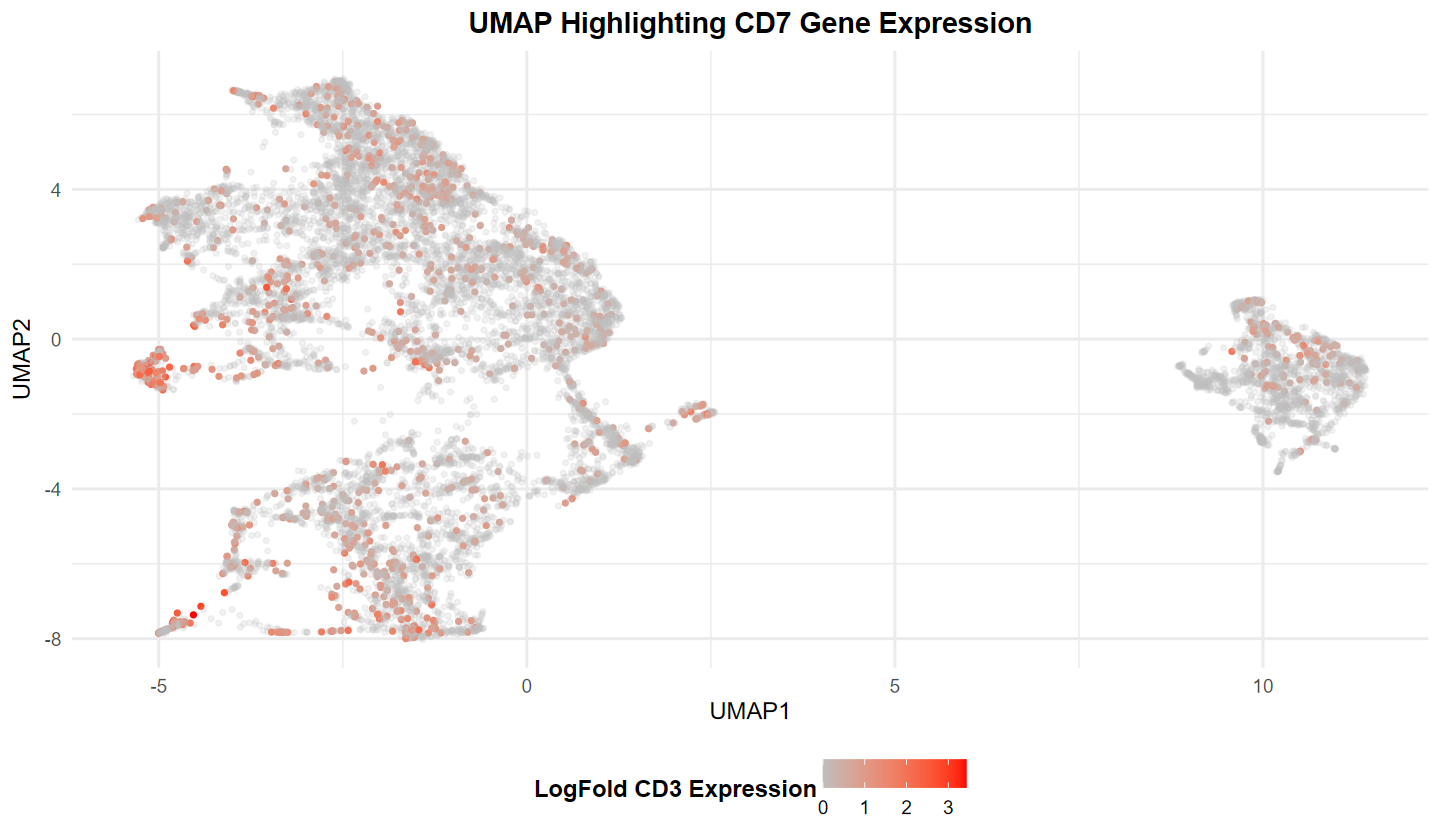

In [162]:
#Visualizing CD3 Expression across all populations and Timepoints

# Assuming "merge2" contains the logcounts assay and CD3 is the gene of interest
library(ggplot2)

# Extract CD3 gene expression values
cd3_expression <- assay(merge2, "logcounts")["CD7", ]

# Add CD3 expression to the UMAP dataframe
umap_df$CD3_expression <- cd3_expression

# Create the plot
gg_umap_cd3 <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(
    aes(color = CD3_expression),
    alpha = ifelse(umap_df$CD3_expression > 0, 1, 0.2),
    size = 1
  ) +
  scale_color_gradient(
    low = "gray",
    high = "red",
    name = "LogFold CD3 Expression"
  ) +
  labs(
    title = "UMAP Highlighting CD7 Gene Expression",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.title = element_text(face = "bold")
  )

print(gg_umap_cd3)


In [138]:
#Establishing T cell Genes 

T_genes <- c("TCF3", "RAG1", "GATA3", "TCF7","NOTCH1","BCL11B", "CD7") 
B_genes <- c("TCF4","PAX5","TCF3","RAG1","RAG2", "BCL11A","EBF1","CD79A","MEF2C" )
gene_presence <- B_genes %in% rownames(merge2)
names(gene_presence) <- B_genes
gene_presence


TCF4   PAX5   TCF3   RAG1   RAG2 BCL11A   EBF1  CD79A  MEF2C 
  TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE

In [136]:
"EBF1" %in% rownames(merge2)

[1] TRUE

In [62]:
unique(pheno.merge2)

[1] "CD34+CD45RA-CLEC12A-" "CD34-CD45RA-CLEC12A+" "CD34+CD45RA-CLEC12A+"
 [4] "CD34+CD45RA+CLEC12A-" "CD34-CD45RA+CLEC12A-" "CD34+CD45RA+CLEC12A+"
 [7] "CD34-CD45RA-CLEC12A-" "CD34-CD45RA+CLEC12A+" "CD14CD15+"           
[10] "CD10+"

In [122]:
# Check unique values in Phenotype_Group
# Check unique values in Phenotype_Group
unique(expression_df$Phenotype_Group)


[1] "Group1" "Group3" "Group2" "Other"  "Group4"

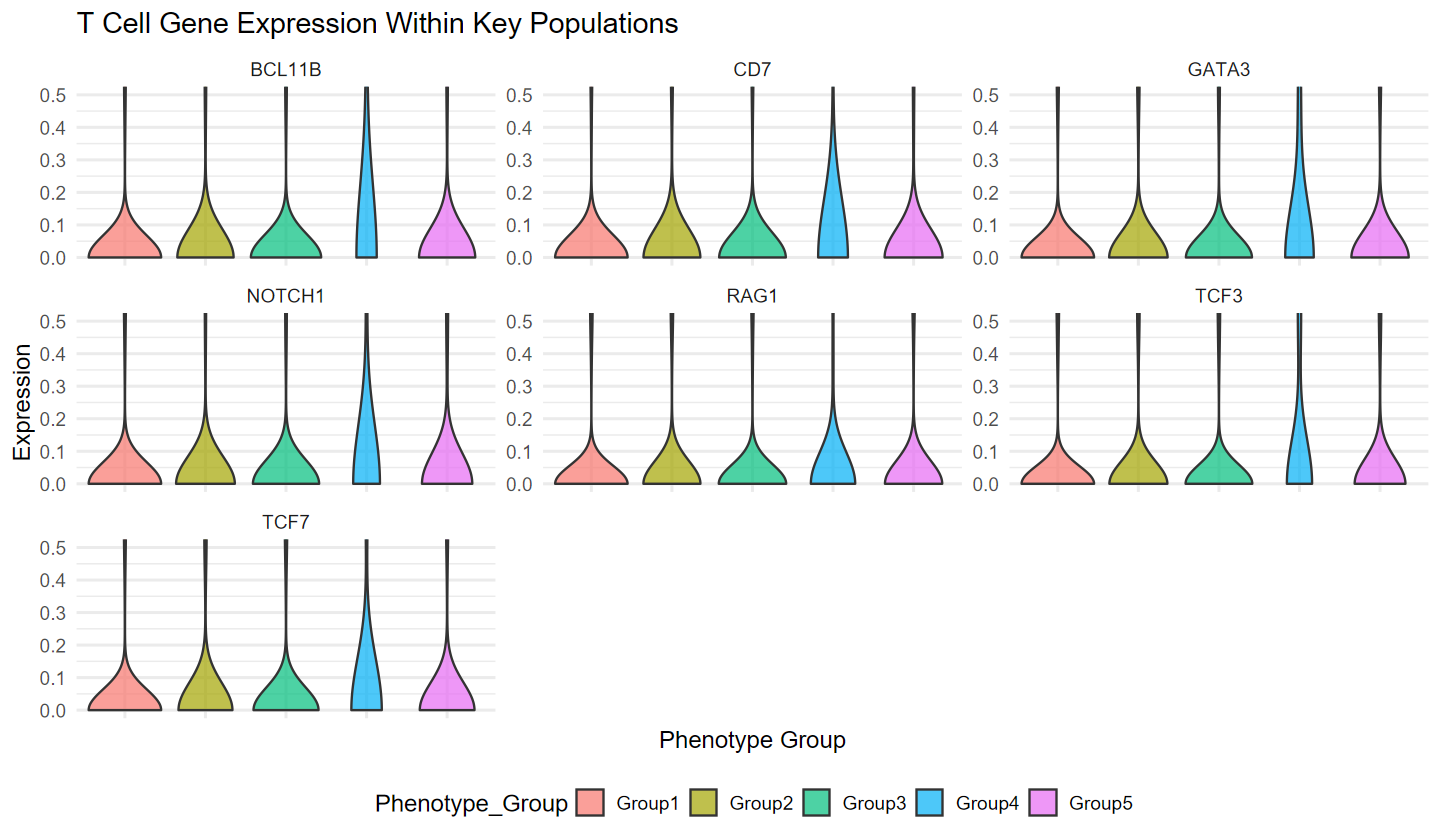

In [139]:
# T Cell Gene Expression Across Starting populations

library(ggplot2)

# Define the genes of interest
genes_of_interest <- T_genes  # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
"CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+")  # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12)  # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~ Gene, scales = "free_y") +
  labs(
    title = "T Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Expression"
  ) +
  coord_cartesian(ylim = c(0, 0.5)) +  # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  )

Great! Now lets do this again with B cell genes 

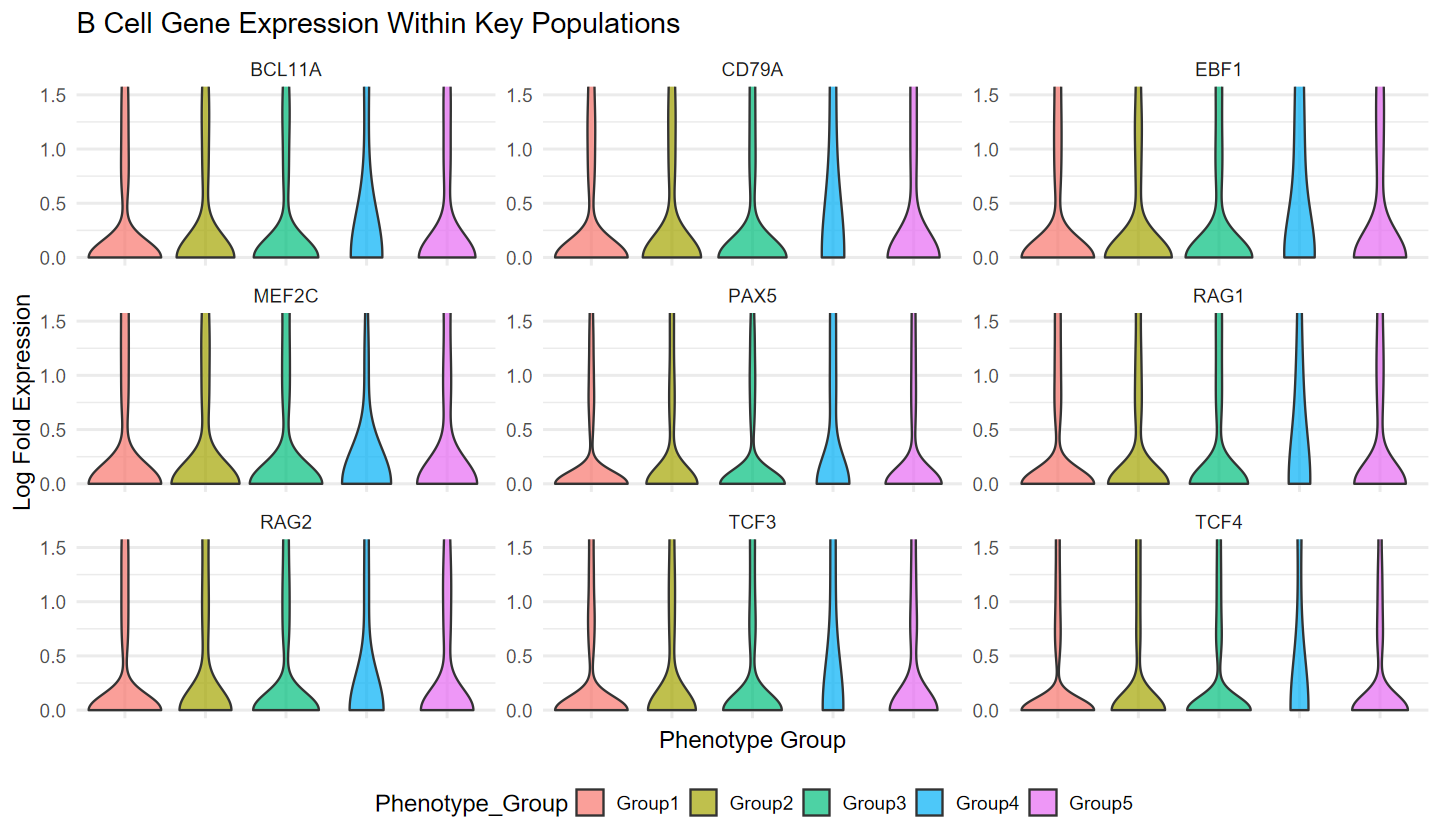

In [142]:
#B Cell Gene Expression Across Populations 






library(ggplot2)

# Define the genes of interest
genes_of_interest <- B_genes  # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
"CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+")  # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12)  # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~ Gene, scales = "free_y") +
  labs(
    title = "B Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Log Fold Expression"
  ) +
  coord_cartesian(ylim = c(0, 1.5)) +  # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  ) 

In [130]:
# Check if CD7 exists in the rownames (genes) of the SCE object
"CD7" %in% rownames(merge2) # Replace merge2 with the name of your SCE object


[1] TRUE

In [ ]:
# head(pheno.merge2)

# merge2

#index.cd10 <- which(pheno.merge2 == "CD10+")
#merge2.cd10 <- merge2[, index.cd10]

#merge2.cd10


cell1Day_7             cell2Day_7             cell3Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" 
            cell4Day_7             cell5Day_7             cell6Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-"